In [80]:
from sklearn.feature_extraction.text import CountVectorizer
import joblib  # for saving and loading sklearn models
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
from sklearn.metrics.pairwise import cosine_similarity


# Function to apply all transformations
def preprocess_data(df, vectorizer=None, fit_vectorizer=True):
    """
    Applies all transformations to the dataframe `df`.
    
    Args:
    - df: pandas DataFrame, input data to transform.
    - vectorizer: CountVectorizer instance, if None a new one will be created and fit.
    - fit_vectorizer: bool, whether to fit the CountVectorizer or not (useful at inference).
    
    Returns:
    - df: transformed pandas DataFrame.
    - vectorizer: fitted CountVectorizer instance.
    """
    
    # Fit and transform the product names
    if vectorizer is None:
        vectorizer = CountVectorizer(binary=True)
    
    if fit_vectorizer:
        X = vectorizer.fit_transform(df['Product Name']).toarray()
    else:
        X = vectorizer.transform(df['Product Name']).toarray()
    
    # Create a DataFrame with the one-hot encoded features
    df_one_hot = pd.DataFrame(X, columns=vectorizer.get_feature_names_out(), index=df.index)
    #df = df.drop(['Product Name'])
    # Concatenate the original DataFrame with the new one-hot encoded DataFrame
    df = pd.concat([df, df_one_hot], axis=1)
    df.fillna(0, inplace=True)
    df['Unit Count'] = df['Unit Count'].replace(0, 1)  # Replace 0 units with 1 to avoid division by zero
    df['true_price'] = df['Price'] / df['Unit Count']
    df['Keyword'] = df['Keyword'].replace({'men': 0, 'women': 1, 'missing': -1})  # Assuming 'missing' as -1 or another category
    
    # One-hot encode 'Category'
    one_hot_encoded = pd.get_dummies(df['Category'], prefix='Category')
    df = df.join(one_hot_encoded)
    
    # Replace spaces with underscores in column names and sort columns
    df.columns = [col.replace(' ', '_') for col in df.columns]
    df = df.sort_index(axis=1)
    
    return df, vectorizer

#df = pd.read_csv('amazon_products_via_rainforest_api.csv')
df2 = pd.read_csv('amazon_products_via_rainforest_api2.csv')
df3 = pd.read_csv('amazon_products_via_rainforest_api3.csv')
df4 = pd.read_csv('amazon_products_via_rainforest_api4.csv')
df5 = pd.read_csv('amazon_products_via_rainforest_api5.csv')
df6 = pd.read_csv('amazon_products_via_rainforest_api6.csv')
df7 = pd.read_csv('amazon_products_via_rainforest_api7.csv')
df5['Price'] = df5['Price'].str.replace('$', '').astype(float)
df6['Price'] = df6['Price'].str.replace('$', '').astype(float)
df7['Price'] = df7['Price'].str.replace('$', '').astype(float)

# Display the first few rows of the dataframe
df = pd.concat([df2,df3,df4,df5,df6,df7], axis=0)
# Example usage during training
df, vectorizer = preprocess_data(df)
df = df.drop_duplicates(subset=['ASIN'])
asinDf = df['ASIN']
df = df.drop(['Product_Name','ASIN',], axis =1)
df = df[df['Category'] != 'soap']

C:\Users\joshf\AppData\Local\Temp\ipykernel_7312\2451303780.py:42: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Keyword'] = df['Keyword'].replace({'men': 0, 'women': 1, 'missing': -1})  # Assuming 'missing' as -1 or another category


In [81]:
# Calculate the average 'true_price' for 'men'
newdf = df[df['Category'] == 'soap']
average_true_price = newdf[newdf['Keyword'] == 1]['true_price'].max()
print(average_true_price)

nan


In [82]:
result = df.groupby(['Category', 'Keyword'])['true_price'].mean().unstack().reset_index()

result.columns = ['Category', 'Median Price for Keyword 0', 'Median Price for Keyword 1']


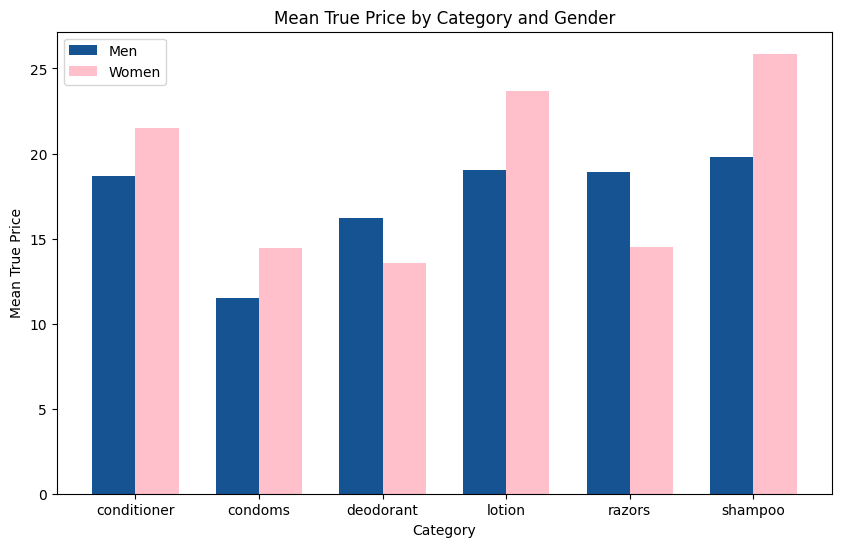

In [83]:
import matplotlib.pyplot as plt

# Plotting the results
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting each category
width = 0.35  # the width of the bars
indices = range(len(result['Category']))  # category indices

bar1 = ax.bar(indices, result['Median Price for Keyword 0'], width, label='Men', color ='#155393')
bar2 = ax.bar([i + width for i in indices], result['Median Price for Keyword 1'], width, label='Women', color ='pink')

# Adding some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Category')
ax.set_ylabel('Mean True Price')
ax.set_title('Mean True Price by Category and Gender')
ax.set_xticks([i + width / 2 for i in indices])
ax.set_xticklabels(result['Category'])
ax.legend()

# Adding value labels above bars
def add_value_labels(ax, bars):
    for bar in bars:
        height = bar.get_height()

add_value_labels(ax, bar1)
add_value_labels(ax, bar2)

plt.show()

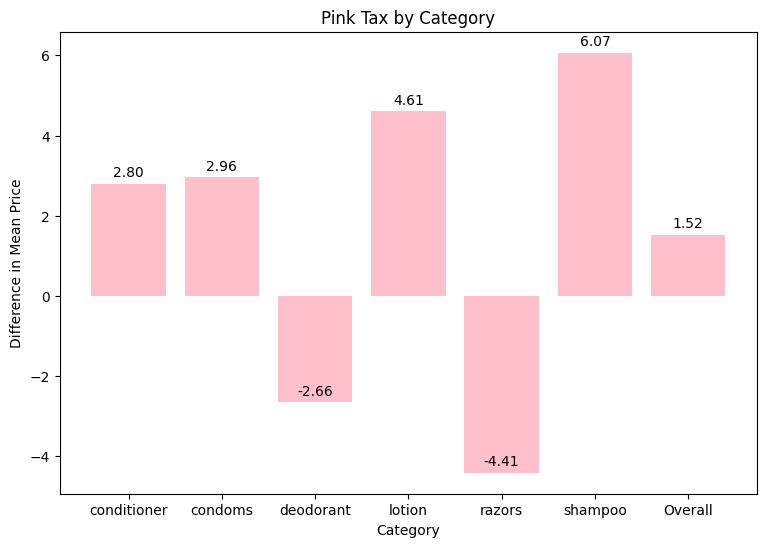

In [98]:
# Calculating the differences in median prices between Keyword 0 and 1 for each category
result['Difference in Median Price'] = result['Median Price for Keyword 1'] - result['Median Price for Keyword 0']
# Calculating the overall median difference across all categories
overall_median_difference = df.groupby('Keyword')['true_price'].mean().diff().iloc[-1]

# Adding the overall difference to the plot
fig, ax = plt.subplots(figsize=(9, 6))
categories = result['Category'].tolist() + ['Overall']
differences = result['Difference in Median Price'].tolist() + [overall_median_difference]

ax.bar(categories, differences, color='pink')

ax.set_xlabel('Category')
ax.set_ylabel('Difference in Mean Price')
ax.set_title('Pink Tax by Category')

# Adding value labels above bars
for i, v in enumerate(differences):
    ax.text(i, v + 0.1, f"{v:.2f}", ha='center', va='bottom')

plt.show()


In [97]:
stars = df[df['Keyword'] == 0]['Average_Review_Score'].mean()
print(stars)

4.6
